In [1]:
import sys, os
sys.path.append("./models/")
sys.path.append("./datasets/")
sys.path.append("./utils/")

In [2]:
import beautydataset
import beautynetv2
import image_preprocess
import beautynet_inference

In [3]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from skimage import io
import face_alignment
import torchvision
import matplotlib.pyplot as plt
import glob
from skimage.transform import resize
import torchvision.transforms as transforms
from PIL import Image
from tqdm import tqdm
import random
import requests

In [4]:
fa = face_alignment.FaceAlignment(face_alignment.LandmarksType._2D, flip_input=False, enable_cuda=True)

In [5]:
def take_breath():
    for i in range(50):
        print()

# 사람의 외모 점수 매기기 #
-----
## Scoring a Person's Beauty ##


In [6]:
take_breath()

# Guilty #
------
## 이런 짓을 해도 되는걸까요? ##
.

.

.

## 주의사항 ##
- **재미로만** 봅시다

In [7]:
def show_multiple_img_and_score(imgs, scores):
    fig = plt.figure(figsize=(15,15))
    num_imgs = len(imgs)
    num_rows = (num_imgs + 2) // 3
    for i in range(num_imgs):
        ax = fig.add_subplot(num_rows, 3, i + 1)
        ax.set_title(u"Beauty Score : %.4f"%(scores[i]))
        ax.imshow(imgs[i])
        ax.axis("off")

In [8]:
taehee = io.imread("./datasets/celebs/celeb3.jpg")
jaeseok = io.imread("./datasets/celebs/celeb4.jpg")
imgs, scores = [taehee, jaeseok], [4.5, 2.5]

# 우리가 원하는 결과 #
---
## 사람 사진을 주면 외모 점수를 계산해준다 ##
- 잔인하지만, 재미로만 봅시다**(거듭 강조)**

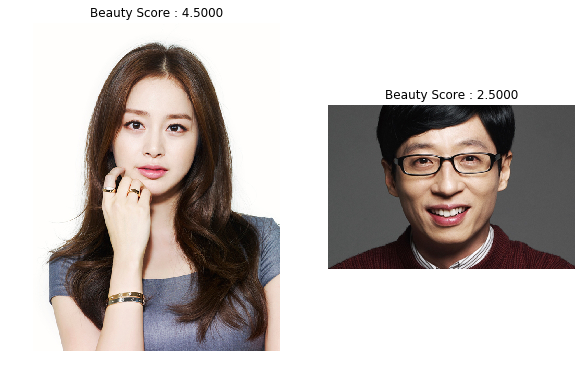

In [9]:
show_multiple_img_and_score(imgs, scores)

# How? #
-----
## **SCUT-FBP5500 Beauty Score Data** ##


- 이런 짓(?) 을 시작한 계기


- 출처 : [SCUT-FBP5500 Beauty Score Data](https://github.com/HCIILAB/SCUT-FBP5500-Database-Release)

![image](https://github.com/HCIILAB/SCUT-FBP5500-Database-Release/blob/master/SCUT-FBP5500.jpg?raw=true)


# 이런 말도 안되는 데이터의 출처는 역시 #
----
## 데이터 출처 ##
### SCUT-FBP5500 ###
- Lingyu Liang, Luojun Lin, Lianwen Jin*, Duorui Xie and Mengru Li 
- South China University of Technology, Guangzhou 510641, China
- 남중국 기술대학교(...)


# 잠시 호흡을 가다듬고 데이터를 봅시다 #
> 이하 출처 [Github](https://github.com/HCIILAB/SCUT-FBP5500-Database-Release)

In [10]:
take_breath()

----

## 2 Database Construction

The SCUT-FBP5500 Dataset can be divided into four subsets with different races and gender, including 2000 Asian females(AF), 2000 Asian males(AM), 750 Caucasian females(CF) and 750 Caucasian males(CM). Most of the images of the SCUT-FBP5500 were collected from Internet, where some portions of Asian faces were from the DataTang, GuangZhouXiangSu and our laboratory, and some Caucasian faces were from the 10k US Adult Faces database.
![image](https://github.com/HCIILAB/SCUT-FBP5500-Database-Release/blob/master/SCUT-FBP5500.jpg?raw=true)

All the images are labeled with beauty scores ranging from [1, 5] by totally 60 volunteers, and 86 facial landmarks are also  located to the significant facial components of each images. We developed a web-based GUI system to obtain the facial beauty scores and facial landmark locations respectively. 

### Training/Testing Set

We use two kinds of experimental settings to evaluate the facial beauty prediction methods on SCUT-FBP5500 benchmark, which includes: 

1) 5-folds cross validation. For each validation, 80% samples (4400 images) are used for training and the rest (1100 images) are used for testing.
2) The split of 60% training and 40% testing. 60% samples (3300 images) are used for training and the rest (2200 images) are used for testing.
We have provided the training and testing files in this link.  

## 3 Evaluation Results

We evaluate three different CNN models on SCUT-FBP5500 dataset for facial beauty prediction using two kinds of experimental settings respectively. Three different evaluation metrics are used, which includes: Pearson correlation (PC), maximum absolute error (MAE), root mean square error (RMSE). 

![image](https://github.com/HCIILAB/SCUT-FBP5500-Database-Release/blob/master/Results%20of%205-folds%20cross%20validations.png?raw=true)
![image](https://github.com/HCIILAB/SCUT-FBP5500-Database-Release/blob/master/Results%20of%20the%20split%20of%2060%25%20training%20and%2040%25%20testing.png?raw=true)

# 요약 #
---
1. 5500장의 사람얼굴사진과 그에 따른 60명이 매긴 얼굴 점수
    - 아시안 여성/남성 각 2000명, 총 4000명
    - 코카시안 여성/남성 각 750명, 총 1500명
2. 각 얼굴 이미지 파일에 해당하는 Facial Landmark 좌표
    - ASM 라이브러리로 구한 좌표를 Manually 수정

In [11]:
take_breath()

# What is Facial Landmark?? #
----
## Facial Landmark Detection ##
- 얼굴 이미지에서의 특징점(랜드마크)을 찾는 일을 말한다.
![image](https://www.learnopencv.com/wp-content/uploads/2015/07/3_det_01.jpg)
- Computer Vision의 오래된 분야로, 딥러닝 이외의 방법도 있고, 딥러닝 방법도 있다. 
- dlib, opencv 등 여러 가지 공개 라이브러리들도 있음
- **저는 자세히는 모르니 궁금하신 분은 공부해서 알려주세요..**


In [12]:
take_breath()

# 학습 방법 #
---
## 우리가 원하는 프로그램 ##
1. 사람 사진을 넣으면
2. 그 사람의 Beauty Score를 계산해주는 프로그램

## 자, 저 데이터셋으로 train-validation set을 나눠서 학습하면될까요? ##

# 문 제 점 #
---
1. 데이터셋의 이미지는 얼굴만 나와있음
    - 우리가 임의의 사진을 넣어 점수를 구하고 싶다면, Face detection도 필요하다.

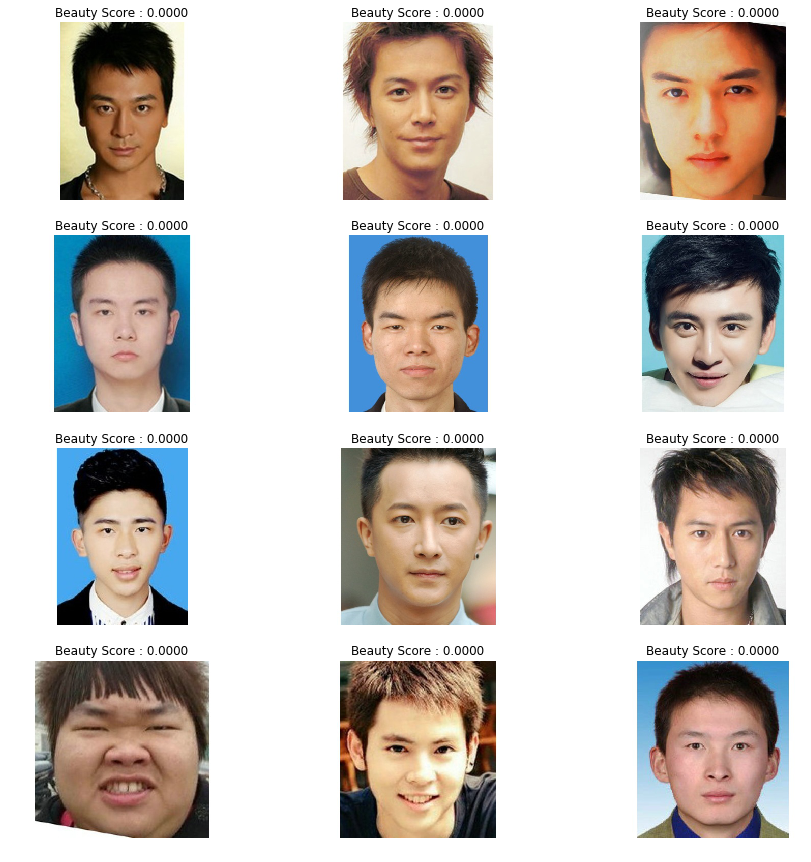

In [13]:
images = [io.imread("./datasets/ImageFolder/mty%d.jpg"%(i)) for i in range(1, 13)]
dummy_score = [0] * 12
show_multiple_img_and_score(images, dummy_score)

  
# 문제점 #
---
2. 데이터셋에 주어진 랜드마크는 어떻게 쓰지?
    - 열심히 페이퍼를 읽어 봐도 .pts 파일의 랜드마크를 어떻게 쓰는 지 모르겠다!
    
    
3. (중요) 랜드마크 파일을 어떻게 읽는지 알아도, 어떻게 만드는 지가 더 중요하다!
    - 우리의 목적은 일반 사진을 넣고 Beauty Score를 구하는 것, 
    - 내가 직접 Face Landmark를 만들어 쓰는게 낫겠다.

# 직접 만들어야 할 데이터 #
---
1. Face Detection
2. Facial Landmark Regression

## [리빙포인트] ##
`자세히 알아보기보단 그냥 라이브러리를 갖다 쓰면 몸과 마음에 평화를 얻을 수 있다 ^^`

In [14]:
take_breath()

# Face detection #

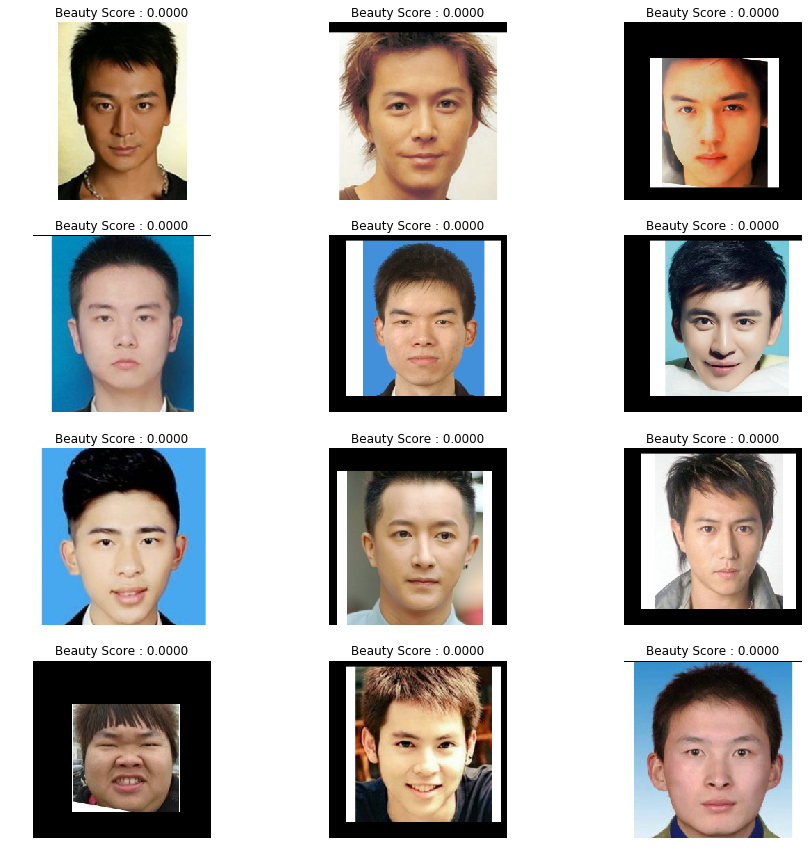

In [15]:
images = [image_preprocess.get_cropped_sample(fa, io.imread("./datasets/ImageFolder/mty%d.jpg"%(i))) for i in range(1, 13)]
dummy_score = [0] * 12
show_multiple_img_and_score(images, dummy_score)

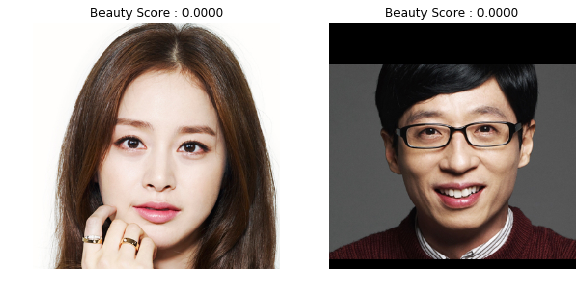

In [16]:
images = [image_preprocess.get_cropped_sample(fa, img) for img in [taehee, jaeseok]]
dummy_score = [0] * 12
show_multiple_img_and_score(images, dummy_score)

In [17]:
def show_img_and_landmarks(img):
    """
    numpy image array -> landmark + image
    return landmark (68 x 2)
    """
    fig = plt.figure(figsize=(15,15))
    ax = fig.add_subplot(121)
    ax.imshow(img)
    ax = fig.add_subplot(122)
    ax.imshow(img)
    markersize = 5
    color = 'red'
    preds = fa.get_landmarks(img)[0]
    # 턱선
    ax.plot(preds[0:17,0],preds[0:17,1],marker='o',markersize=markersize,linestyle='-',color=color,lw=2)
    # 오른눈썹
    ax.plot(preds[17:22,0],preds[17:22,1],marker='o',markersize=markersize,linestyle='-',color=color,lw=2)
    # 왼눈썹
    ax.plot(preds[22:27,0],preds[22:27,1],marker='o',markersize=markersize,linestyle='-',color=color,lw=2)
    # 콧대
    ax.plot(preds[27:31,0],preds[27:31,1],marker='o',markersize=markersize,linestyle='-',color=color,lw=2)
    # 콧구멍라인
    ax.plot(preds[31:36,0],preds[31:36,1],marker='o',markersize=markersize,linestyle='-',color=color,lw=2)
    # 오른눈
    ax.plot(preds[36:42,0],preds[36:42,1],marker='o',markersize=markersize,linestyle='-',color=color,lw=1)
    # 왼눈
    ax.plot(preds[42:48,0],preds[42:48,1],marker='o',markersize=markersize,linestyle='-',color=color,lw=2)
    # 입술 밖
    ax.plot(preds[48:60,0],preds[48:60,1],marker='o',markersize=markersize,linestyle='-',color=color,lw=2)
    # 입술 안
    ax.plot(preds[60:68,0],preds[60:68,1],marker='o',markersize=markersize,linestyle='-',color=color,lw=2)
    ax.axis('off')
    return preds

/home/jongho/anaconda3/envs/pt4/lib/python3.6/site-packages/face_alignment-0.1.0-py3.6.egg/face_alignment/api.py:185: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


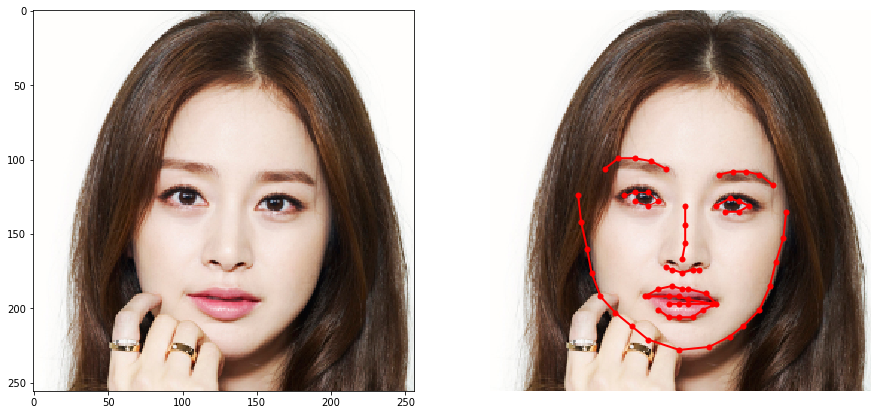

In [18]:
landmarks = show_img_and_landmarks(image_preprocess.get_cropped_sample(fa, taehee))

In [19]:
landmarks

array([[ 59., 124.],
       [ 61., 142.],
       [ 65., 160.],
       [ 68., 176.],
       [ 74., 192.],
       [ 84., 203.],
       [ 95., 212.],
       [106., 221.],
       [127., 228.],
       [147., 226.],
       [161., 219.],
       [170., 212.],
       [181., 201.],
       [188., 185.],
       [192., 169.],
       [197., 153.],
       [199., 135.],
       [ 77., 106.],
       [ 86.,  99.],
       [ 97.,  99.],
       [108., 101.],
       [118., 106.],
       [154., 110.],
       [163., 108.],
       [172., 108.],
       [181., 110.],
       [190., 117.],
       [131., 131.],
       [131., 144.],
       [131., 156.],
       [129., 167.],
       [118., 172.],
       [122., 174.],
       [129., 176.],
       [136., 174.],
       [140., 174.],
       [ 90., 124.],
       [ 97., 122.],
       [106., 122.],
       [113., 128.],
       [106., 131.],
       [ 97., 128.],
       [152., 131.],
       [161., 126.],
       [167., 128.],
       [174., 131.],
       [167., 135.],
       [158.,

# Data Preprocess #
---
## 일반적인 이미지 데이터의 프리프로세싱 ##
1. 이미지를 긁어모은다
2. 모델에 필요한 이미지 해상도에 맞게 자르거나 resize, 라벨링
3. Augmentation
    - 회전
    - 뒤집기
    - 크롭하기
    - 등등..
    
    


In [20]:
take_breath()

## BeautyNet 훈련을 위한 이미지 프리프로세싱 ##
1. (이미지를 긁어모은다) -> 데이터는 이미 주어져있음
    - 얼굴 이미지와 그에 따른 Beauty Score, 이걸 추가로 모은다는 것은 어렵다

2. (모델에 필요한 이미지 해상도에 맞게 자르거나 resize, 라벨링) -> 모델에 필요한 이미지 해상도는 256x256이고, 데이터셋의 이미지는 350x350임
    - 와! 랜덤크롭을 해서 써도 되겠다!
    - 라고 생각했으나..
    
### 얼굴 Detection을 학습 중 동적으로 생성된 이미지에 사용하기 어렵다! ###
- 사용중인 얼굴 detection library : 
    
    `dlib : 너무 느림`

    `s3fd : cuda 모델인데 beautynet과 함께 메모리에 올릴 수 없음 ㅠ`

### 같은 이유로 landmark detection도 학습 중에 in-line으로 사용할 수 없음 ###
- 사용중인 face landmark detector : face-alignment-net

    `fan : cuda 모델인데 마찬가지로 메모리 부족`
    


# 그래서, 제한되는 augmentation #
----
1. Random Cropping
2. 회전 및 뒤집기 (가능은 한데.. landmark heatmap상에서는 어려움. 귀찮으니 안함)

## 할 수 있는 augmentation ##
- 이미지 색상 장난질 등 위치정보를 보전하는 변환들

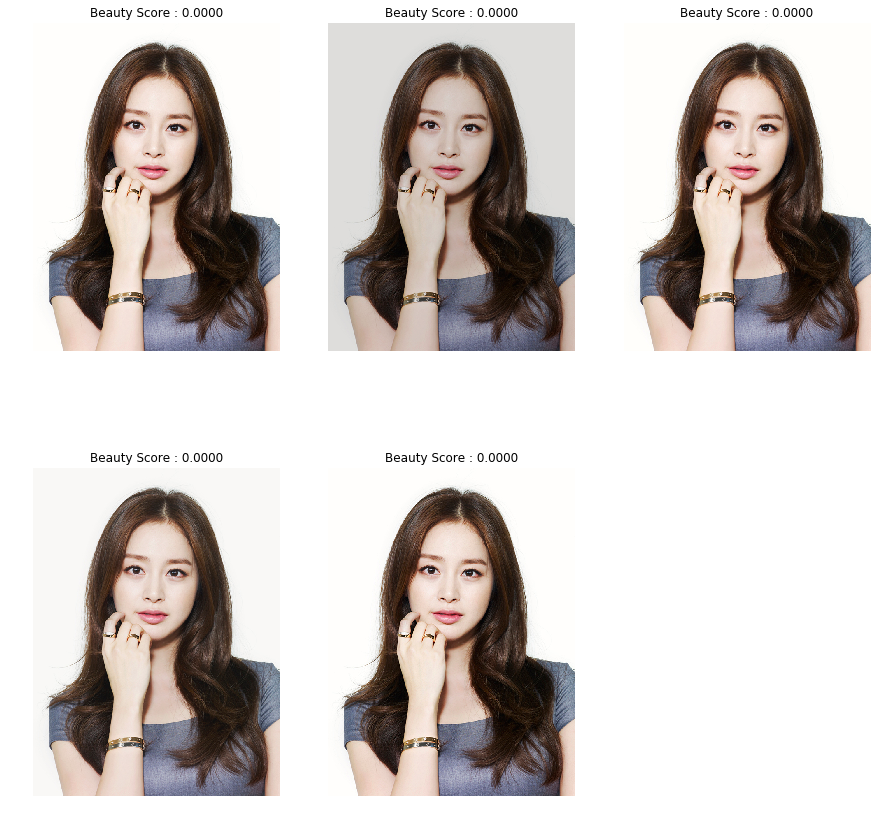

In [21]:
ptaehee = Image.fromarray(taehee)
bright = image_preprocess.RandomEnhanceBrightness(ptaehee)
color = image_preprocess.RandomEnhanceColor(ptaehee)
contrast = image_preprocess.RandomEnhanceContrast(ptaehee)
sharp = image_preprocess.RandomEnhanceSharpness(ptaehee)

show_multiple_img_and_score([ptaehee, bright, color, contrast, sharp], [0, 0, 0, 0, 0])

# 처음의 모델 #
---
- Input : image(350 x 350 rgb 3channel) + landmark channel(1, 0의 값을 갖는 1 channel) 이렇게 해서 4채널 이미지 입력을 갖는 이미지
- Model : Modified Resnet(4채널 입력을 받도록)
- MSE Loss 0.23
- 추가설명은 오프라인으로

# 문제점 #
---
- 사실 문제점인진 잘 모르겠지만
- 랜드마크 채널을 잘 못쓰지 않을까 하는 생각
- 랜드마크 채널이 좀 더 풍성하면 좋겠어요

# Face Alignment Network #
---
> TODO:: 간단하게 네트워크 구조랑 페이퍼 소개 (10분 이상)

In [22]:
var_inp = torch.tensor(image_preprocess.get_cropped_sample(fa, taehee)).permute(2,0,1).float().div(255.0).unsqueeze(0).cuda()
out = fa.face_alignemnt_net(var_inp)
landmark_heatmap = out[-1].data
landmark_heatmap.shape

torch.Size([1, 68, 64, 64])

# 수정된 모델 #
---
- Input : image (256 x 256 rgb 3channel), landmark heatmap(68 x 64 x 64 tensor)
- Model : Resnet + Resnet
- 추가설명은 오프라인으로

In [23]:
model_path = "./checkpoints/beautynetv2_04251556.best"  # MSE Loss 0.1485
net = beautynetv2.BeautyNetV2().cuda()
net = beautynet_inference.load_model(net, model_path)
net

BeautyNetV2(
  (resnet): ResNet256(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running

# Demo #
---


/home/jongho/anaconda3/envs/pt4/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
/home/jongho/anaconda3/envs/pt4/lib/python3.6/site-packages/matplotlib/axes/_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


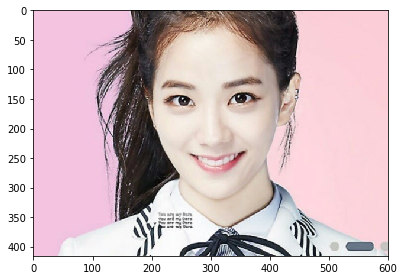

In [24]:
filename = "./datasets/celebs/celeb12.jpg"
image_original = io.imread(filename)
io.imshow(image_original)

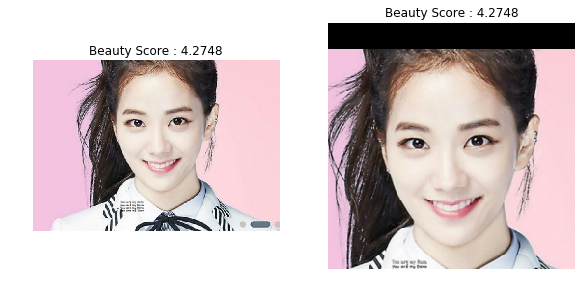

In [25]:
score = beautynet_inference.inference_image(fa, net, filename)
cropped_image = image_preprocess.get_cropped_sample(fa, image_original)
show_multiple_img_and_score([image_original, cropped_image], [score, score])

/home/jongho/anaconda3/envs/pt4/lib/python3.6/site-packages/face_alignment-0.1.0-py3.6.egg/face_alignment/api.py:185: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


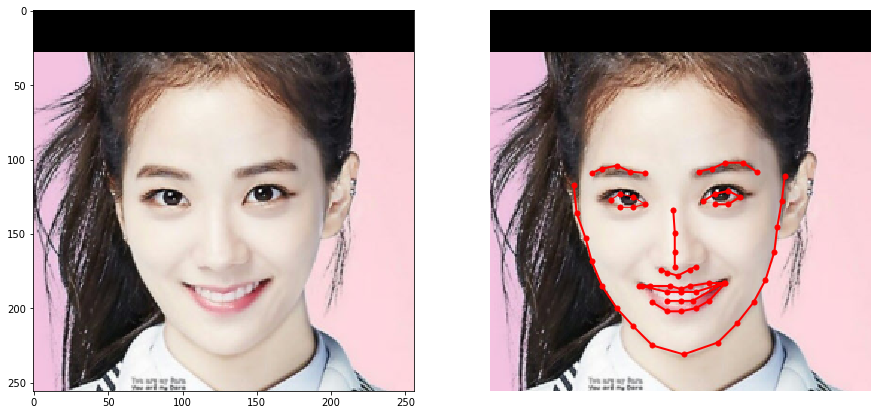

In [26]:
_ = show_img_and_landmarks(cropped_image)

In [27]:
url = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQZxW3iiacuDXgxDdocPYV4gcjsBi6aoUv7_gI69YrJvO5ncqCQkw"
img = Image.open(requests.get(url, stream=True).raw)
np.array(img).shape

(168, 300, 3)

/home/jongho/anaconda3/envs/pt4/lib/python3.6/site-packages/face_alignment-0.1.0-py3.6.egg/face_alignment/api.py:185: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


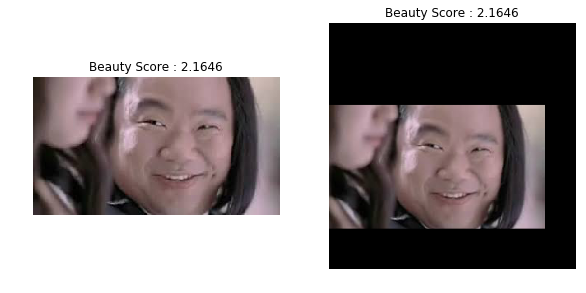

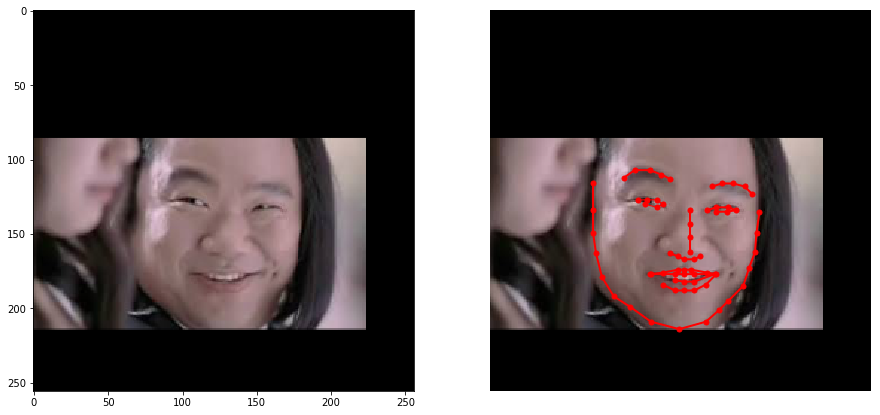

In [28]:
score = beautynet_inference.inference_image(fa, net, img)
cropped_image = image_preprocess.get_cropped_sample(fa, np.array(img))
show_multiple_img_and_score([img, cropped_image], [score, score])
_ = show_img_and_landmarks(cropped_image)